# Load Dataset from Google Drive

In [2]:
import os
from google.colab import drive
drive.mount('/content/drive')
# !unzip  drive/Shareddrives/Bangkit\ Capstone/leaf_datasets.zip -d .

Mounted at /content/drive


# Import Libraries

In [51]:
import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
from shutil import copyfile
import matplotlib.pyplot as plt

In [3]:
train_dir = './Segmented Medicinal Leaf Images/train'
test_dir = './Segmented Medicinal Leaf Images/test'

In [8]:
def list_images(train_dir, test_dir):
  classes_dirs = os.listdir(train_dir)
  count = 0 
  for folder in classes_dirs:
    train_classes = os.listdir(os.path.join(train_dir, folder))
    test_classes = os.listdir(os.path.join(test_dir, folder))
    total_classes = len(train_classes) + len(test_classes)
    if total_classes < 50:
      continue
    print(f"{folder}: \n \t{len(train_classes)} train images and {len(test_classes)} test images,  total {len(train_classes) + len(test_classes)} images")
    count += 1
  print(f"{count} total classes")
list_images(train_dir, test_dir)

Ruku-ruku: 
 	36 train images and 16 test images,  total 52 images
Lemon: 
 	39 train images and 18 test images,  total 57 images
Oleander: 
 	43 train images and 19 test images,  total 62 images
Mondokaki: 
 	39 train images and 17 test images,  total 56 images
Mint: 
 	67 train images and 30 test images,  total 97 images
Tanaman Ara Suci: 
 	44 train images and 19 test images,  total 63 images
Kersen: 
 	39 train images and 17 test images,  total 56 images
Delima: 
 	55 train images and 24 test images,  total 79 images
Mimba: 
 	42 train images and 18 test images,  total 60 images
Kelor: 
 	53 train images and 24 test images,  total 77 images
Jambu Mawar: 
 	39 train images and 17 test images,  total 56 images
Jeruk Purut: 
 	36 train images and 16 test images,  total 52 images
Mangga: 
 	43 train images and 19 test images,  total 62 images
Jambu Biji: 
 	45 train images and 20 test images,  total 65 images
Bayam Malabar: 
 	72 train images and 31 test images,  total 103 images
Malap

In [19]:
# Load the first example of a horse
def image_shapes():
  classes_dirs = os.listdir(train_dir)
  for folder in classes_dirs:
    if folder == "Jeruk Purut":
      continue
    classes = os.listdir(os.path.join(train_dir, folder))
    print(folder)
    sample_image  = load_img(f"{os.path.join(train_dir ,folder, classes[0])}")
    # # Convert the image into its numpy array representation
    sample_array = img_to_array(sample_image)
    print(f"Each {folder} image has shape: {sample_array.shape}")
image_shapes()

Ruku-ruku
Each Ruku-ruku image has shape: (1200, 1600, 3)
Kembang Sepatu
Each Kembang Sepatu image has shape: (1200, 1600, 3)
Jamblang
Each Jamblang image has shape: (1200, 1600, 3)
Sawi India
Each Sawi India image has shape: (1200, 1600, 3)
Sirih
Each Sirih image has shape: (1200, 1600, 3)
Lemon
Each Lemon image has shape: (1200, 1600, 3)
Oleander
Each Oleander image has shape: (1200, 1600, 3)
Mondokaki
Each Mondokaki image has shape: (1200, 1600, 3)
Mint
Each Mint image has shape: (1200, 1600, 3)
Tanaman Ara Suci
Each Tanaman Ara Suci image has shape: (1200, 1600, 3)
Kersen
Each Kersen image has shape: (1200, 1600, 3)
Delima
Each Delima image has shape: (1200, 1600, 3)
Mimba
Each Mimba image has shape: (1200, 1600, 3)
Kelor
Each Kelor image has shape: (1200, 1600, 3)
Jambu Mawar
Each Jambu Mawar image has shape: (1200, 1600, 3)
Mangga
Each Mangga image has shape: (1200, 1600, 3)
Jambu Biji
Each Jambu Biji image has shape: (1200, 1600, 3)
Bayam Malabar
Each Bayam Malabar image has sha

In [26]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
  train_datagen = ImageDataGenerator(rescale = 1./255.,
                              rotation_range = 25,
                              zoom_range = [0.5, 1.1],
                              width_shift_range=0.15, 
                              shear_range= 0.15,
                              height_shift_range=0.15,
                              preprocessing_function=preprocess_input,
                              horizontal_flip=True,
                              vertical_flip= True,
                              fill_mode='nearest',)

  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=32, 
                                                      class_mode='sparse',
                                                      target_size=(225, 225))

  validation_datagen = ImageDataGenerator(rescale = 1/255,
                                          preprocessing_function=preprocess_input)

  # Pass in the appropriate arguments to the flow_from_directory method
  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=32, 
                                                                class_mode='sparse',
                                                                target_size=(225, 225))
  ### END CODE HERE
  return train_generator, validation_generator

In [27]:
train_generator, validation_generator = train_val_generators(train_dir, test_dir)

Found 1308 images belonging to 32 classes.
Found 577 images belonging to 32 classes.


In [38]:
## Loading VGG16 model
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(225, 225, 3))
base_model.trainable = False ## Not trainable weights

## Preprocessing input

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(50, activation='relu')
dense_layer_2 = layers.Dense(20, activation='relu')
prediction_layer = layers.Dense(32, activation='softmax')


model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)


# es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True)


In [39]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_4 (Flatten)         (None, 25088)             0         
                                                                 
 dense_12 (Dense)            (None, 50)                1254450   
                                                                 
 dense_13 (Dense)            (None, 20)                1020      
                                                                 
 dense_14 (Dense)            (None, 32)                672       
                                                                 
Total params: 15,970,830
Trainable params: 1,256,142
Non-trainable params: 14,714,688
_________________________________________________________________


In [40]:

# history = model.fit(train_generator,  epochs=15,  validation_data=validation_generator)
history = model.fit(train_generator,
                    epochs=15,
                    verbose=1,
                    validation_data=validation_generator)

Epoch 1/15
41/41 [==============================] - 74s 1s/step - loss: 3.3960 - accuracy: 0.0734 - val_loss: 3.0459 - val_accuracy: 0.1109
Epoch 2/15
41/41 [==============================] - 57s 1s/step - loss: 3.0282 - accuracy: 0.1437 - val_loss: 2.5398 - val_accuracy: 0.2097
Epoch 3/15
41/41 [==============================] - 57s 1s/step - loss: 2.5976 - accuracy: 0.2791 - val_loss: 2.0617 - val_accuracy: 0.4333
Epoch 4/15
41/41 [==============================] - 56s 1s/step - loss: 2.2024 - accuracy: 0.3677 - val_loss: 1.7409 - val_accuracy: 0.5321
Epoch 5/15
41/41 [==============================] - 57s 1s/step - loss: 1.9184 - accuracy: 0.4404 - val_loss: 1.4087 - val_accuracy: 0.5979
Epoch 6/15
41/41 [==============================] - 57s 1s/step - loss: 1.5739 - accuracy: 0.5229 - val_loss: 1.2184 - val_accuracy: 0.6170
Epoch 7/15
41/41 [==============================] - 57s 1s/step - loss: 1.3547 - accuracy: 0.5841 - val_loss: 0.9411 - val_accuracy: 0.7036
Epoch 8/15
41/41 [==

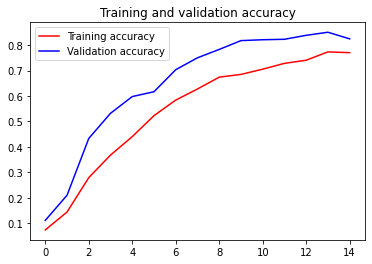

<Figure size 432x288 with 0 Axes>

In [41]:
def plot_loss(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  
  epochs = range(len(acc))
  
  plt.plot(epochs, acc, 'r', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend(loc=0)
  plt.figure()
  
  plt.show()

plot_loss(history)

In [44]:
def load_image(img_path, show=False):

    img = load_img(img_path, target_size=(225, 225))
    img_tensor = img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

    if show:
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show()

    return img_tensor

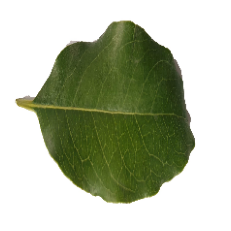

Cendana


In [50]:
label_map = (train_generator.class_indices)
label_map = {v: k for k, v in label_map.items()}
image_path ='/content/Segmented Medicinal Leaf Images/test/Cendana/SA-S-005.jpg'
image = load_image(image_path, show=True)
print(label_map[np.argmax(model.predict(image))])

In [ ]:
image = load_img('/content/Segmented Medicinal Leaf Images/test/Bayam Hijau/AV-S-009.jpg')

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1600x1200 at 0x7EFCCAC16990>


array([ 0,  0,  0, ..., 31, 31, 31], dtype=int32)